# Importando bibliotecas

In [ ]:
import logging
import numpy as np
import os
import time
from datetime import datetime
import sys
import os
sys.path.append(os.path.join('..'))
from classes._LoadInstances import LoadInstances
from classes._Env3WGym import Env3WGym
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel

# Código Otimizado

In [ ]:
import os
import time
import logging
from datetime import datetime
import sys
import numpy as np  # Import necessário para uso do np.where e operações com arrays
sys.path.append(os.path.join('..'))
from classes._LoadInstances import LoadInstances
from classes._Env3WGym import Env3WGym, make_custom_vec_env
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel

def setup_logger(directory: str, event_name: str, type_instance: str, ts: int, model_type: str) -> logging.Logger:
    """
    Configura e retorna o logger global 'global_logger' com o padrão:
    '{current_time}_{event_name}-{type_instance}_{model_type}_{ts}.log'
    """
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f'{current_time}_{event_name}-{type_instance}_{model_type}_{ts}.log'
    full_path = os.path.join(directory, log_filename)
    os.makedirs(directory, exist_ok=True)
    
    logger = logging.getLogger("global_logger")
    logger.setLevel(logging.INFO)
    if logger.hasHandlers():
        logger.handlers.clear()
    handler = logging.FileHandler(full_path, mode='w', encoding='utf-8')
    formatter = logging.Formatter(
        '[%(levelname)s]\t%(asctime)s - %(message)s',
        datefmt='%d/%m/%Y %I:%M:%S %p'
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.propagate = False  # Impede que as mensagens se propaguem para o logger raiz

    return logger

def train_evaluate_model(agente: Agent, model_type: str, path_model: str,
                         ts: int, logger: logging.Logger,
                         supervised: Supervised = None) -> dict:
    """
    Realiza o treinamento e a avaliação do modelo para um valor de timesteps (ts),
    retornando um dicionário com 'accuracy', 'model_agent' e o valor de timesteps.
    """
    final_result = None   
    agente.TIMESTEPS = ts
    logger.info(f"Iniciando treinamento do algoritmo {model_type} com {ts} timesteps")
    start_time = time.time()
    try:
        if model_type == 'DQN':
            model_agent, _ = agente.env3W_dqn(path_save=path_model)
        elif model_type == 'PPO':
            model_agent = agente.env3W_ppo(path_save=path_model)
        elif model_type == 'A2C':
            model_agent = agente.env3W_a2c(path_save=path_model)
        elif model_type == 'RNA':
            model_agent = supervised.keras_train()
        else:
            raise ValueError("Modelo não implementado")
        train_time = round(time.time() - start_time, 2)
        print(f"Tempo de Treinamento {model_type}: {train_time}s")
        logger.info(f"Tempo de Treinamento {model_type}: {train_time}s")
    except Exception as e:
        logger.error(f"Erro ao treinar o modelo {model_type}: {e}")
        return final_result

    try:
        logger.info(f"Iniciando avaliação do algoritmo {model_type} no conjunto de teste")
        start_time = time.time()
        if model_type == 'DQN':
            accuracy = agente.env3W_dqn_eval(model=model_agent, path_save=path_model)
        elif model_type == 'PPO':
            accuracy = agente.env3W_ppo_eval(model=model_agent, path_save=path_model)
        elif model_type == 'A2C':
            accuracy = agente.env3W_a2c_eval(model=model_agent, path_save=path_model)
        elif model_type == 'RNA':
            accuracy = supervised.keras_evaluate(model_agent)
        else:
            raise ValueError("Modelo não implementado")
        eval_time = round(time.time() - start_time, 2)
        print(f"Acurácia: {accuracy * 100:.2f}% | Tempo de Avaliação: {eval_time}s")
        logger.info(f"Acurácia: {accuracy:.5f} com {ts} timesteps")
        final_result = {"timesteps": ts, "model_agent": model_agent, "accuracy": accuracy}
    except Exception as e:
        logger.error(f"Erro ao avaliar o modelo {model_type}: {e}")
    return final_result

if __name__ == '__main__':
    # Configuração inicial e carregamento dos dados
    events_names = {
       # 0: 'Normal',
       1: 'Abrupt Increase of BSW',
       #2: 'Spurious Closure of DHSV',
       #3: 'Severe Slugging',
       #4: 'Flow Instability',
       #5: 'Rapid Productivity Loss',
       #6: 'Quick Restriction in PCK',
       #7: 'Scaling in PCK',
       #8: 'Hydrate in Production Line',
    }
    models = ['DQN', 'PPO']  # Opções: 'DQN', 'PPO', 'A2C', 'RNA'
    type_instance = 'real'  # Outras opções: 'simulated', 'real'
    path_dataset = os.path.join('..', '..', '..', 'dataset')
    instances = LoadInstances(path_dataset)

    logging.info('Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)
    logging.info('Fim carregamento do dataset')

    logging.info('Iniciando divisão do dataset em treino, teste e validação')
    train_percentage = 0.8
    list_timesteps = [1000, 10000, 100000, 150000, 300000]  # , 150000, 300000

    final_results = {}
    # Itera sobre cada evento utilizando o código (key) e o nome (value)
    for code, event in events_names.items():
        if code == 0:
            continue

        # Filtra o dataset de acordo com a coluna 'code'
        dataset_filtered = dataset[dataset[:, -1] == code]
        if dataset_filtered.size == 0:
            logging.warning(f"Nenhum dado encontrado para o código {code} ({event}). Pulando...")
            continue
        
        dataset_filtered = dataset_filtered[:, :-1] # Remove a coluna 'code' do dataset
        # Prepara os conjuntos de treino, teste e validação para o evento atual
        dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = \
            instances.data_preparation(dataset_filtered, train_percentage)
        
        # Configuração dos ambientes de treino e teste
        envs_train = make_custom_vec_env(dataset_train_scaled, n_envs=5, vec_env_type='dummy')
        envs_test  = make_custom_vec_env(dataset_test_scaled, n_envs=1, vec_env_type='dummy')

        path_tensorboard = os.path.join('..', 'models', f"{event}-{type_instance}")
        os.makedirs(path_tensorboard, exist_ok=True)
        agente = Agent(path_tensorboard, envs_train, envs_test)  

        for model_type in models: 
            for ts in list_timesteps:                                    
                
                log_dir = os.path.join('..', '..', 'logs', f"{event}-{type_instance}")
                path_model = os.path.join('..', 'models', f"{event}-{type_instance}", model_type)
                os.makedirs(log_dir, exist_ok=True)
                os.makedirs(path_model, exist_ok=True)

                # Configura o logger global com o valor de timesteps incluso no nome do arquivo
                logger_model = setup_logger(log_dir, event, type_instance, ts, model_type)
                logger_model.info(f"Iniciando execução do algoritmo {model_type}-{type_instance} para o evento {event} com {ts} timesteps")

                # Caso o modelo seja RNA, ajusta os rótulos e instancia o objeto supervised
                if model_type == 'RNA':
                    dataset_train_scaled[:, -1] = np.where(dataset_train_scaled[:, -1] == 101, 1, dataset_train_scaled[:, -1])
                    dataset_test_scaled[:, -1] = np.where(dataset_test_scaled[:, -1] == 101, 1, dataset_test_scaled[:, -1])
                    supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
                else:
                    supervised = None

                result = train_evaluate_model(agente, model_type, path_model, ts, logger_model, supervised)
                if result:
                    final_results[(model_type, event)] = result
                    accuracy = result["accuracy"]
                    model_agent = result["model_agent"]
                    print(f"Final accuracy for {model_type} on event {event} with {result['timesteps']} timesteps: {accuracy * 100:.2f}%")
                    
                    # Validação do modelo
                    logger_model.info(f"Iniciando a validação do modelo {model_type}")
                    validation = ValidationModel(model_type, event, ts)
                    validation.validation_model(result["accuracy"], dataset_validation_scaled, model_agent)
                    logger_model.info(f"Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event}")

                    # Fecha os handlers do logger para liberar recursos
                    for handler in logger_model.handlers[:]:
                        handler.close()
                        logger_model.removeHandler(handler)


# Validação dos dados simulados

In [ ]:

def get_global_logger(logs_directory: str, event_name: str, type_instance: str, model_type: str) -> logging.Logger:
    """
    Configura e retorna um objeto de logger global.
    Se já estiver configurado, retorna o mesmo objeto.
    
    O nome do arquivo de log seguirá o padrão:
    '{directory}\{current_time}_{event_name}-{type_instance}_{model_type}-log'
    """
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f'{current_time}_{event_name}-{type_instance}_{model_type}-log'
    full_path = os.path.join(logs_directory, log_filename)
    os.makedirs(logs_directory, exist_ok=True)
    
    logger = logging.getLogger("global_logger")
    if not logger.handlers:
        logger.setLevel(logging.INFO)
        handler = logging.FileHandler(full_path, mode='w', encoding='utf-8')
        formatter = logging.Formatter(
            '[%(levelname)s]\t%(asctime)s - %(message)s',
            datefmt='%d/%m/%Y %I:%M:%S %p'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

def run_model_training_evaluation(agente: Agent, model_type: str, path_model: str,
                                  list_timesteps: list, logger: logging.Logger,
                                  supervised: Supervised = None) -> dict:
    """
    Realiza o treinamento e avaliação do modelo conforme o tipo e retorna um dicionário
    contendo 'accuracy' e 'model_agent' da última iteração bem-sucedida.
    """
    final_result = None
    for ts in list_timesteps:
        agente.TIMESTEPS = ts
        logger.info(f"Iniciando treinamento do algoritmo {model_type} com {ts} timesteps")
        start_time = time.time()
        try:
            if model_type == 'DQN':
                model_agent, _ = agente.env3W_dqn(path_save=path_model)
            elif model_type == 'PPO':
                model_agent = agente.env3W_ppo(path_save=path_model)
            elif model_type == 'A2C':
                model_agent = agente.env3W_a2c(path_save=path_model)
            elif model_type == 'RNA':
                model_agent = supervised.keras_train()
            else:
                raise ValueError("Modelo não implementado")
            train_time = round(time.time() - start_time, 2)
            print(f"Tempo de Treinamento {model_type}: {train_time}s")
            logger.info(f"Tempo de Treinamento {model_type}: {train_time}s")
        except Exception as e:
            logger.error(f"Erro ao treinar o modelo {model_type}: {e}")
            continue

        try:
            logger.info(f"Iniciando avaliação do algoritmo {model_type} no conjunto de teste")
            start_time = time.time()
            if model_type == 'DQN':
                accuracy = agente.env3W_dqn_eval(model=model_agent, path_save=path_model)
            elif model_type == 'PPO':
                accuracy = agente.env3W_ppo_eval(model=model_agent, path_save=path_model)
            elif model_type == 'A2C':
                accuracy = agente.env3W_a2c_eval(model=model_agent, path_save=path_model)
            elif model_type == 'RNA':
                accuracy = supervised.keras_evaluate(model_agent)
            else:
                raise ValueError("Modelo não implementado")
            eval_time = round(time.time() - start_time, 2)
            print(f"Acurácia: {accuracy * 100:.2f}% | Tempo de Avaliação: {eval_time}s")
            logger.info(f"Acurácia: {accuracy:.5f}")
            final_result = {"timesteps": ts, "model_agent": model_agent, "accuracy": accuracy}
        except Exception as e:
            logger.error(f"Erro ao avaliar o modelo {model_type}: {e}")
    return final_result

if __name__ == '__main__':
    

    # Definição dos eventos (serão usados apenas os eventos com chave diferente de zero)
    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'       
    }
    # Para o tensorboard, utiliza o primeiro evento disponível
    event_name_tensorboard = list(events_names.values())[0]

    models = ['DQN']  # Opções: 'DQN', 'PPO', 'A2C', 'RNA'
    type_instance = 'real'  # Alternativas: 'real', 'simulated'
    path_dataset = os.path.join('..', '..', '..', 'dataset')
    instances = LoadInstances(path_dataset)

    # Configura o logger global com o padrão de nomenclatura solicitado
    logs_directory = os.path.join('..', '..', 'logs')
    # Utilizamos o primeiro modelo da lista para definir o nome do arquivo de log
    model_type_for_log = models[0]
    logger = get_global_logger(logs_directory, event_name_tensorboard, type_instance, model_type_for_log)
    logger.info('Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)
    logger.info('Fim carregamento do dataset')

    # Divisão do dataset em treino, teste e validação
    train_percentage = 0.8
    dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

    # Configuração dos ambientes de treino e teste
    env_train = Env3WGym(dataset_train_scaled, n_envs=5)
    env_test = Env3WGym(dataset_test_scaled, n_envs=1)
    envs_train = env_train.envs_random()
    envs_test = env_test.envs_random()

    # Diretório para salvar os modelos/tensorboard
    path_tensorboard = os.path.join('..', 'models', f"{event_name_tensorboard}-{type_instance}")
    os.makedirs(path_tensorboard, exist_ok=True)

    # Instancia o agente com os ambientes configurados
    agente = Agent(path_tensorboard, envs_train, envs_test, TIMESTEPS=1000)

    list_timesteps = [100000]  # Exemplos: 1000, 10000, etc.

    # Dicionário para armazenar os resultados finais de cada combinação (modelo, evento)
    final_results = {}

    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:
            # Cria os diretórios para os modelos (os logs já são gerenciados pelo logger global)
            directory = os.path.join('..', '..', 'logs', f"{event_name}-{type_instance}")
            path_model = os.path.join('..', 'models', f"{event_name}-{type_instance}", model_type)
            os.makedirs(directory, exist_ok=True)
            os.makedirs(path_model, exist_ok=True)

            logger.info(f"Iniciando execução do algoritmo {model_type}-{type_instance} para o evento {event_name} com timesteps {agente.TIMESTEPS}")

            # Para o modelo RNA, ajusta os rótulos e instancia o objeto supervised
            if model_type == 'RNA':
                dataset_train_scaled[:, -1] = np.where(dataset_train_scaled[:, -1] == 101, 1, dataset_train_scaled[:, -1])
                dataset_test_scaled[:, -1] = np.where(dataset_test_scaled[:, -1] == 101, 1, dataset_test_scaled[:, -1])
                supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
            else:
                supervised = None

            # Executa o treinamento e avaliação utilizando o logger global
            result = run_model_training_evaluation(agente, model_type, path_model, list_timesteps, logger, supervised)
            if result:
                accuracy = result["accuracy"]
                model_agent = result["model_agent"]
                final_results[(model_type, event_name)] = result
                print(f"Final accuracy for {model_type} on event {event_name} with {result['timesteps']} timesteps: {accuracy*100:.2f}%")
                # As variáveis 'accuracy' e 'model_agent' estão disponíveis para uso posterior

            logging.info(f'Iniciando a validação do modelo {model_type}') 
            validation = ValidationModel(model_type, event_name)
            validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event_name}')
            # Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
            for handler in logging.root.handlers[:]:
                handler.close()
                logging.root.removeHandler(handler)

    # Exemplo: acesso aos resultados armazenados
    # print(final_results)


In [ ]:
logging.info(f'Iniciando a validação do modelo {model_type}') 
validation = ValidationModel(model_type, event_name)
validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

logging.info(f'Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event_name}')
# Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
for handler in logging.root.handlers[:]:
    handler.close()
    logging.root.removeHandler(handler)

# Validação com dados reais

In [ ]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        # 1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
         3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' 
    type_instance= 'real' # real, simulated
    path_dataset = '..\\..\\..\\dataset'
    instances = LoadInstances(path_dataset)
    model_type = models[0]
            
    logging.info(f'Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
    logging.info(f'Fim carregamento do dataset')    
    
    logging.info(f'Iniciando divisão do dataset em treino e teste')        
    # Definindo a porcentagem para divisão entre treino e teste
    train_percentage = 0.8  # 80% para treino
    dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)
   
    env_train = Env3WGym(dataset_train_scaled, n_envs = 5)
    env_test = Env3WGym(dataset_test_scaled, n_envs = 1)

    envs_train = env_train.envs_random()
    envs_test = env_test.envs_random()

    env_test_cl = Env3WGym(dataset_test_scaled, n_envs = 5)
    envs_cl = env_test_cl.envs_random()

    directory = f'..\\..\\logs\\{event_name}-{type_instance}-CL'
    path_dataset = '..\\..\\..\\dataset'   
    path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

    if not os.path.exists(directory):
        os.makedirs(directory)

    if not os.path.exists(path_model):
        os.makedirs(path_model)    

    path_tensorboard = f'..\\models\\{event_name}-{type_instance}-CL'   
    if not os.path.exists(path_tensorboard):
        os.makedirs(path_tensorboard)

    agente = Agent(path_tensorboard, envs_train, envs_test, TIMESTEPS = 100000)            

            
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
    # Configuração do Logging
    logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, 
                        format='[%(levelname)s]\t%(asctime)s - %(message)s', 
                        datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')
   

    if model_type == 'DQN':
        
        logging.info(f'Iniciando o teste do algoritmo DQN (Continual Learning)')    
        #start_time = time.time()
        #model_agent = agente.env3W_dqn(path_save=path_model)  
        #print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
        #logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
        #logging.info(f'Fim treinamento do algoritmo DQN')
        

        # Carrega o modelo treinado em simulação com 100k passos
        path_model_zip = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN", "_DQN.zip")
        
        # Avalia o modelo treinado em simulação com 100k passos no ambiente real
        model_agent = DQN.load(path_model_zip) 
        logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
        accuracy = agente.env3W_dqn_eval(model = model_agent, path_save=path_model)
        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
        logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')

        # Carrega o replay buffer do modelo treinado em simulação com 100k passos 
        replay_buffer_path = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN", "replay_buffer", "dqn_save_replay_buffer.pkl")
        
        # Retreina o modelo com o replay buffer do modelo treinado em simulação com 10k passos do modelo real
        model_agent_cl = agente.env3W_dqn_cl(model_agent = model_agent, path_save=path_model, envs = envs_cl, 
                                             replaydir = replay_buffer_path, total_timesteps = 50000)
        
        # Avalia o modelo retreinado com 10k passos do ambiente real
        logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste (Continual Learning)')
        accuracy = agente.env3W_dqn_eval(model = model_agent_cl, path_save=path_model)
        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN (Continual Learning)')
        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN (Continual Learning)')
        logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste (Continual Learning)')   

    # Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
    for handler in logging.root.handlers[:]:
        handler.close()
        logging.root.removeHandler(handler)
    

# Geração de gráficos

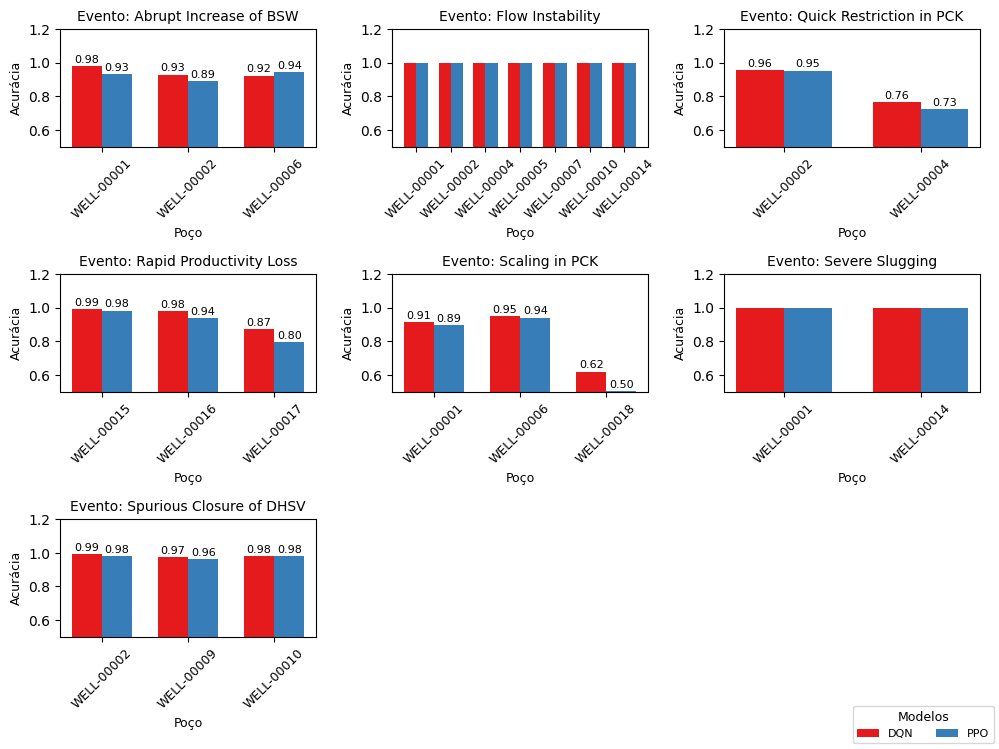

In [18]:
# Re-import libraries after environment reset
import pandas as pd
import matplotlib.pyplot as plt
import math

# Load the uploaded file
file_path = "..\\..\\metrics\\acc_by_well.csv"
df = pd.read_csv(file_path)

# Agrupar os dados por evento, modelo e poço, tirando a média da acurácia (caso tenha duplicatas)
mean_acc = df.groupby(['event_name', 'model_name', 'well'])['accuracy'].mean().reset_index()

# Obter os eventos únicos
events = mean_acc['event_name'].unique()

# Usar cores fixas para cada modelo
model_colors = dict(zip(df['model_name'].unique(), plt.cm.Set1.colors[:len(df['model_name'].unique())]))

# Criar subplots por evento
cols = 3
rows = math.ceil(len(events) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 2.5 * rows))
axes = axes.flatten()

# Plotar cada evento com os dois modelos no mesmo gráfico
for i, event in enumerate(events):
    ax = axes[i]
    event_data = mean_acc[mean_acc['event_name'] == event]
    wells = sorted(event_data['well'].unique())

    # Posição das barras agrupadas
    x = range(len(wells))
    width = 0.35

    for j, model in enumerate(model_colors.keys()):
        model_data = event_data[event_data['model_name'] == model].set_index('well').loc[wells]
        bar_pos = [xi + (j - 0.5) * width for xi in x]
        bars = ax.bar(bar_pos, model_data['accuracy'], width=width, label=model, color=model_colors[model])

        # Adicionar rótulo nas barras
        for bar in bars:
            height = bar.get_height()
            # Mostrar apenas se for diferente de 1.00
            if round(height, 2) != 1.00:
                ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}',
                        ha='center', va='bottom', fontsize=8)


    ax.set_title(f'Evento: {event}', fontsize=10)
    ax.set_xlabel('Poço', fontsize=9)
    ax.set_ylabel('Acurácia', fontsize=9)
    ax.set_xticks(x)
    ax.set_xticklabels(wells, rotation=45, fontsize=9)
    ax.set_ylim(0.5, 1.2)
    
    #ax.legend(fontsize=8)

# Esconder subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legenda única fora dos subplots
fig.legend(model_colors.keys(), title="Modelos", loc='lower right', ncol=len(model_colors), fontsize=8, title_fontsize=9)

plt.tight_layout()
plt.show()


# Exploração dos dados

In [ ]:
events_names = {
    1: 'Normal',
    #2: 'Abrupt Increase of BSW',
    #3: 'Spurious Closure of DHSV',
    #4: 'Severe Slugging',
    #5: 'Flow Instability',
    #6: 'Rapid Productivity Loss',
    #7: 'Quick Restriction in PCK',
    #8: 'Scaling in PCK',
    #9: 'Hydrate in Production Line'
}


path_dataset = '..\\..\\..\\dataset'
type_instance = 'real'

# Initialize instances
instances = LoadInstances(path_dataset)

# Load the dataset
dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance) 


In [ ]:
# Assuming 'dataset' is your numpy array
df = pd.DataFrame(dataset, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'])
df.head()

In [ ]:
event_name = 'Spurious Closure of DHSV'

explora = exploration(pd.DataFrame(dataset, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']))

#explora.quartiles_plot(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], f'Quartis das variáveis {type_instance} do evento {event_name}')

In [ ]:
event_name = 'Normal'

explora.heatmap_corr(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], f'Correlação das variáveis {type_instance} do evento {event_name}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the attribute for plotting
attribute = 'P-PDG'

# Extract the data for the selected attribute and filter by

attribute_data = df[attribute].dropna()

# Plotting the density plot for the selected attribute
plt.figure(figsize=(10, 6))
sns.kdeplot(data=attribute_data, fill=True, label=f"{attribute}")
plt.title(f'Density Plot for the dataset - {attribute}')
plt.xlabel(attribute)
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
from scipy.stats import gaussian_kde


# Plotting density plots as subplots for specified columns
attributes = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
# Creating density plots in a grid layout (3 columns) with distinct colors
colors = ['blue', 'green', 'red', 'orange', 'purple']
n_cols = 3
n_rows = -(-len(attributes) // n_cols)  # Ceiling division to get the number of rows
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

axes = axes.flatten()  # Flatten to simplify indexing

for i, attribute in enumerate(attributes):
    attribute_data = df[attribute].astype(float)
    density = gaussian_kde(attribute_data)
    x_vals = np.linspace(attribute_data.min(), attribute_data.max(), 1000)
    density_vals = density(x_vals)
    
    # Plotting each density
    axes[i].plot(x_vals, density_vals, color=colors[i % len(colors)], label=attribute)
    axes[i].fill_between(x_vals, density_vals, color=colors[i % len(colors)], alpha=0.3)
    #axes[i].set_title(f'Density Plot: {attribute}')
    axes[i].set_xlabel(attribute)
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Hide any unused subplots
for j in range(len(attributes), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
